# Lab 2: Style Transfer
*Team Members:*
- Yasmin Femerling
- Alejandro de Leon

March, 2021

 In this lab we implement a photo realistic style transfer algorithm using the work of Li et al. in their universal style transfer paper. [1]
 
 ## Encoder Decoder Construction

In [1]:
from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras import layers, applications, losses
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D
import tensorflow.keras.backend as K
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
import pathlib 
from pathlib import Path, PurePath

import skimage
from skimage.transform import resize

import sys
import os
import h5py

from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import Callback
import numpy as np
from PIL import Image

from tensorflow.python.framework.ops import enable_eager_execution
enable_eager_execution()


We will make use of a VGG encoder and a decoder to make the style transfer. Style transfer is seen as an image reconstruction task, so the encoder will extract features from an image to then apply a transformation that will allow for style transfer. Once the transformation is done, the VGG decoder can reconstruct the image from the transformed features. 

In the code below we construct a decoder based on the work of Justinledford [2]. The decoder is based on the VGG model that will be seen below. The VGG layers are composed of convolutional layers and MaxPooling. To make a decoder, the use of convolutional layers and UpSampling is needed, making the reverse process. 

A few corrections were made to the decoder. First, it is based on numbered layers. The VGG encoder-decoder can be made with different relu layers from the 5 blocks of the VGG. How far along the layers the decoder goes in the VGG encoder, is how far along on the layers the decoder has to go in inverse. The convolutional layers are normally 3x3, but in the layer right after an upsampling, we change it to 4x4 to have it be an integer of the upsampling. 


In [2]:
# The decoder makes the inverse from the encoder layers
def decoder_layers(inputs, layer):
    
    x = inputs
    
    if layer >= 5: 
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
        x = Conv2D(512, (4, 4), activation='relu', padding='same', name='decoder_block4_conv4')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
        
    if layer >= 4: 
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
        x = Conv2D(256, (4, 4), activation='relu', padding='same', name='decoder_block3_conv4')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    
    
    if layer >= 3:

        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
        x = Conv2D(128, (4, 4), activation='relu', padding='same', name='decoder_block2_conv2')(x)
     
    if layer >= 2: 
        x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
        x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
        x = Conv2D(64, (4, 4), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    
    if layer >= 1:
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    
    return x

Because the VGG encoder's job will be to extract features, this does not have to be trained. That is why the VGG layers will be constructed using the weights from fchollet's release. [3] We do not need the top layers from VGG because there will be no classification. 

In [3]:
# Function that will count the number of samples in a directory (including its subdirectories)
def count_num_samples(directory):
    total=0
    for root, dirs, files in os.walk(directory):
        total += len(files)
    return total

# Weights from the trained VGG
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

MEAN_PIXEL = np.array([103.939, 116.779, 123.68])

# Get weights without top
WEIGHTS_PATH = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')

# Making the VGG until the desired relu layer. 
def vgg_layers(inputs, target_layer):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    return x


# The layers were made to match the weights
def load_weights(model):
    f = h5py.File(WEIGHTS_PATH)
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    f.close()

def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - MEAN_PIXEL

# Making the VGG function
def VGG19(img_in=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if img_in is not None:
        if len(K.int_shape(img_in)) == 3:
            img_in = K.expand_dims(img_in, axis=0)
        
        img_in = preprocess_input(img_in)
    
    if img_in is None:
        
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=img_in, shape=input_shape)
        
    print(inputs)
    
    
    
    model = Model(inputs, vgg_layers(inputs, target_layer), name="vgg19")
    load_weights(model)
    
    return model



We have the functions that will create an encoder and a decoder. To make a model from them, the encoder output must be the new input of the decoder. They will be joined using a sequential keras model and we will create a loss function that takes into account both the content of the image and the features of the image. That way, the model can be trained based on the substraction of the input image and the reconstructed image (how much the content is similar) and the substraction of the VGG features from the input image and the reconstructed image. The better the decoder can be trained, the better the style transfer can be done. 

In [4]:
LAMBDA=1

# L2 is used for the loss function 
def l2_loss(x):
    return K.sum(K.square(x)) / 2
    
## STYLE-TRANSFER LOSS
CONTENT_TRAINING_SIZE = (256, 256, 3)

# This class will hold the encoder and the decoder using the above functions
class EncoderDecoder:
    
    # The encoder and decoder will be initialized based on the input_shape and the target layer 
    # that we specify
    
    def __init__(self, input_shape=(256, 256, 3), target_layer=5,
                 decoder_path=None):
        self.input_shape = input_shape
        self.target_layer = target_layer
        
        # The encoder will have the desider input shape and go until the target layer
        self.encoder = VGG19(input_shape=self.input_shape, target_layer=target_layer)
        
        # The decoder will be created based on the target layer
        self.decoder = self.create_decoder(target_layer)
        
        self.model = Sequential()
        self.model.add(self.encoder)
        self.model.add(self.decoder)
        
         # We make a vgg that will be used in the loss function
        self.vgg_loss = VGG19(input_shape=self.model.output_shape, target_layer=target_layer)
        
        # We create the loss function
        self.loss = self.create_loss_fn()

        self.model.compile('adam', self.loss)
        self.model.summary()
        
    def create_loss_fn(self):

        def custom_loss(y_true, y_pred):
            content_image = y_true
            reconstructed_image = y_pred
            
            # We take into account the content and the features of the 
            # output "reconstructed"  image for the loss function
            encoding_in = self.vgg_loss(content_image)
            encoding_out = self.vgg_loss(reconstructed_image)
            
            # We take the l2 loss of both
            return l2_loss(reconstructed_image - content_image) + \
                   LAMBDA*l2_loss(encoding_out - encoding_in)
        
        return custom_loss

    def create_decoder(self, target_layer):
        
        # We create the decoder by getting the output of the encoder as the new input
        inputs = Input(shape=self.encoder.output_shape[1:])
        layers = decoder_layers(inputs, target_layer)
        
        # We add the final activation layer
        output = Conv2D(3, (3, 3), activation='relu', padding='same', name='decoder_out')(layers)
        decoder = Model(inputs, output, name='decoder_%s' % target_layer)
        
        return decoder

    # Function to save the encoderdecoder, with a name based on the target layer
    def export_decoder(self):
        self.decoder.save('decoder_night_%s.h5' % self.target_layer)

## Train Model
We will now train the model. The encoder is fixed, so only the decoder needs to be trained. We will make two models, one for target layer 2 and one for target layer 4. 

In [ ]:
TRAIN_PATH = 'dogcat/dataset/train-chill'
VAL_PATH = 'dogcat/dataset/test-chill' 
TARGET_SIZE = (256, 256)
BATCH_SIZE = 8
epochs = 4
target_layer = 2

# We use image data generator to have batches input for training
# we preprocess the input for the VGG
def create_gen(img_dir, target_size, batch_size):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    gen = datagen.flow_from_directory(img_dir, target_size=target_size,
                                      batch_size=batch_size, class_mode=None)

    def tuple_gen():
        for img in gen:
            if img.shape[0] != batch_size:
                continue

            # (X, y)
            yield (img, img)

    return tuple_gen()


# Creating generators
# One is for training and the other for validation
train_gen = create_gen(TRAIN_PATH, TARGET_SIZE, BATCH_SIZE)
validation_gen = create_gen(VAL_PATH, TARGET_SIZE, BATCH_SIZE)

# Steps per epoc calculation
num_samples = count_num_samples(TRAIN_PATH)
steps_per_epoch = num_samples // BATCH_SIZE

# Validation steps calculation
num_samples = count_num_samples(VAL_PATH)
validation_steps = num_samples // BATCH_SIZE

# Initializing encoder-decoder
encoder_decoder = EncoderDecoder(target_layer=target_layer)


# Training model
# We use the fit function and specify the training
# and validation data to have both
H = encoder_decoder.model.fit(train_gen, 
                              steps_per_epoch = steps_per_epoch,
                              validation_data=validation_gen,
                              validation_steps=validation_steps,
                              epochs = epochs, 
                             )

# Saving decoder
encoder_decoder.export_decoder()

The EncoderDecoders were trained and the following results were obtained: 

## Encoder-Decoder A (Layer 2)

## Encoder-Decoder B (Layer 4)

## Encoder-Decoder C (Layer 2)

The results were not good. Below are the plots of the models from layer 2 (A) and layer 4 (B): 


In [ ]:
# Plot model training loss and validation loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot-%d.png" % target_layer)

## Model A Plot

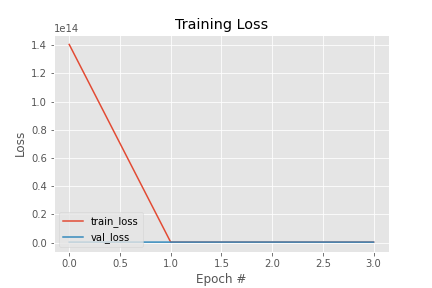

## Model B Plot

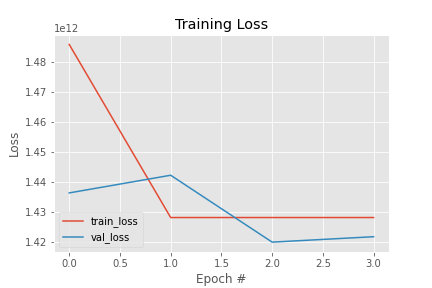

## Evaluate decoder
We now test and evaluate the encoder-decoder for an image reconstruction process.

In [ ]:
DECODER_PATH = 'decoder_4.h5'
INPUT_IMG_PATH = 'dogcat/dataset/train-chill/cats/cat.3.jpg'
OUTPUT_IMG_PATH = 'dog_recon.jpg'
TARGET_LAYER = 4

encoder_decoder = EncoderDecoder(decoder_path=DECODER_PATH, target_layer=TARGET_LAYER)

# We load the test image from the input path
input_img = image.load_img(INPUT_IMG_PATH, target_size = (256, 256))

# Transform the image into an array
input_img = image.img_to_array(input_img)

# Preprocess
input_img = preprocess_input(input_img)

# Expand dimensions to match the input of the model 'batches'
input_img = np.expand_dims(input_img, axis=0)

# Use the model to predict
output_img = encoder_decoder.model.predict([input_img])[0]

output_img /= np.amax(output_img)

# Save the image
plt.imsave(OUTPUT_IMG_PATH, output_img)

The predictions of the encoder-decoder were not successful. This could be caused for the lack of training of the model.

**Original content image**

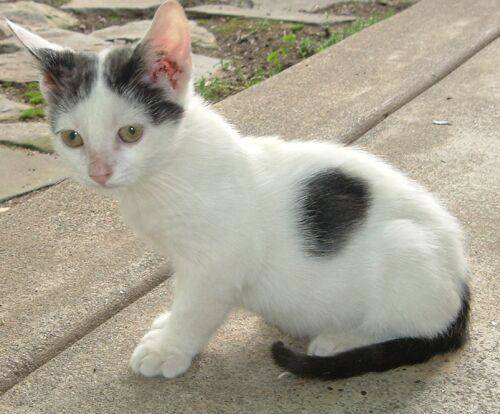

**Reconstructed content image**

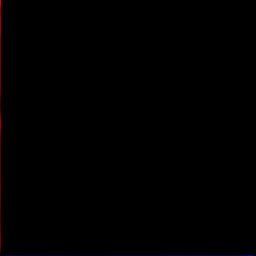

Because the training of our encoder-decoder model did not yield such good results, we will be using a pretrained autoencoder to show images and their reconstructions. The autoencoder was taken from Yihao Wang's code. [4] The autoencoder shown below is taken from his work. 